In [1]:
import torch
import torch.nn as nn
from scipy.io import loadmat
import numpy as np
import random as rand
import mlmodel
import math
import pickle as pkl
import chart_studio.plotly as py
from importlib import reload
import plotly.graph_objects as go
from functools import reduce

import pose_2D as pose2d
import pose_3D as pose3d
import visual as vs

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
pose2d = reload(pose2d)
pose3d = reload(pose3d)
vs = reload(vs)

In [3]:
torch.cuda.is_available()

True

In [4]:
#device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
torch.cuda.current_device()

0

## 1- Load

In [6]:
inputs, labels = pkl.load(open( "data/TRAIN.pkl", "rb" ))

### b- Sample the large data

In [7]:
sample_size = 900000
sample_inputs, sample_labels = zip(*rand.sample(list(zip(inputs, labels)), 2*sample_size))

In [8]:
train_inputs = np.array(list(sample_inputs[:int(1.8*sample_size)]))
train_labels = np.array(list(sample_labels[:int(1.8*sample_size)]))
val_inputs = np.array(list(sample_inputs[int(1.8*sample_size):]))
val_labels = np.array(list(sample_labels[int(1.8*sample_size):]))

In [9]:
val_labels.shape

(180000, 9)

### c- add random input occlusion

In [10]:
def add_occlusion(pedestrian):
    dim = int(pedestrian.shape[0]/14)
    pedestrian = pedestrian.reshape((14,dim)).transpose()
    states = [ 'left wrist occluded', 'right wrist occluded', ]

## 2- create and prepare model

In [11]:
net = mlmodel.LinearModel(59, 9, num_stage=3)

In [12]:
net = net.to(device)

### a- prepare data loader and learning rate decay

In [13]:
class PrepareData(Dataset):
    def __init__(self, X, Y):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X).float()
        
        if not torch.is_tensor(Y):
            self.Y = torch.from_numpy(Y).float()
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [14]:
loss = nn.MSELoss()
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.8
    epochs_drop = 50.0
    lrate = initial_lrate * math.pow(drop,
                                     math.floor((1+epoch)/epochs_drop))
    return lrate

In [15]:
size_batches = 500
ds = PrepareData(X=train_inputs, Y=train_labels)

ds = DataLoader(ds, batch_size = size_batches, shuffle=True)



### b- infer data and find error between ground truth and prediction

In [16]:
def infer(inputs, model):
    with torch.no_grad():
        net = model
        net = net.to(device)
        net.eval()
        inputs = torch.from_numpy(inputs).float().to(device)
        outputs = net(inputs)
        outputs.cpu().detach().numpy()
    return outputs

In [17]:
def find_error(inputs, gt, model):
    pred = infer(inputs, model).cpu().numpy()
    return np.mean(np.linalg.norm(gt-pred, axis = 1))

## 3- Train

In [ ]:
losses = []
for epoch in range(400):
    optimizer = optim.Adam(net.parameters(), lr=step_decay(epoch))
    e_loss = []
    for i, data in enumerate(ds, 0):
        batch_inputs, batch_labels = data
        (batch_inputs, batch_labels) = (batch_inputs.to(device), batch_labels.to(device))
        
        optimizer.zero_grad()
        
        batch_outputs = net(batch_inputs)
        
        l = loss(batch_outputs, batch_labels)
        
        l.backward()
        optimizer.step()
        
        e_loss.append(l)
    
    print(epoch, 'train loss:', find_error(train_inputs,train_labels, net),
          '\t val loss:', find_error(val_inputs,val_labels, net))
        
        

0 train loss: 2.376132969258658 	 val loss: 2.3753886297205145
1 train loss: 0.8022998088305885 	 val loss: 0.8034058771110596
2 train loss: 0.823512033708519 	 val loss: 0.8257898109652195
3 train loss: 0.7249766553690631 	 val loss: 0.7261926171891039
4 train loss: 0.7335730183360529 	 val loss: 0.733547276417939
5 train loss: 0.7190911156183065 	 val loss: 0.721365868576867
6 train loss: 0.5910101379288629 	 val loss: 0.5922991594906346
7 train loss: 0.6161877822827134 	 val loss: 0.6187016247414732
8 train loss: 0.685556467083662 	 val loss: 0.687599456656315
9 train loss: 0.6169897392380436 	 val loss: 0.6182466770500532
10 train loss: 0.5659012125800826 	 val loss: 0.5679350722342472
11 train loss: 0.5959996872418855 	 val loss: 0.597240729035647
12 train loss: 0.6442894765997955 	 val loss: 0.6469154002664675
13 train loss: 0.5547477721482775 	 val loss: 0.5569622578574867
14 train loss: 0.4923412254900977 	 val loss: 0.4958139555164385
15 train loss: 0.5160835568706026 	 val lo

In [215]:
name = 'net-v0_3.pkl'
torch.save(net.state_dict(), name)

In [49]:
params = torch.load('net-v0_3.pkl')
net.load_state_dict(params)

<All keys matched successfully>

## 4- visualize a validation result

In [50]:
i = 150000
test = infer(val_inputs[i:i+1],net).cpu().numpy()[0]
gt = val_labels[i]
print(test)
print(gt)

[ 0.24382015 -1.5826442   0.2046133  -0.25947875 -0.7698832   0.5201479
 -0.6312052   1.0490929  -0.5324652 ]
[ 0.78539816 -1.57079633  0.78539816 -0.26179939 -0.78539816  0.52359878
 -0.62831853  1.04719755 -0.52359878]


In [51]:
props = inputs[i][42:]
list_body = ['neck','shoulder','biceps','forearm','quad','tibias','hip','back']
list_face = ['nose', 'eye', 'ear']

In [52]:
body_props = dict(zip(list_body, props[:8]))
face_pos = dict(zip(list_face, props[8:].reshape((3,3))))

In [53]:
base_3d_pose = pose2d.generate_3D_model(body_props, face_pos)

In [54]:
(a0,a1,a2,a3,a4,a5,a6,a7,a8) = gt
angle_dic = {'head':[a0,a1,a2], 'back':[a3,a4,a5], 'x':[a6],'y':[a7], 'z':[a8]}
gt_pose = pose3d.full_pose_rotation(base_3d_pose.reshape((21,3)).transpose(), angle_dic).transpose().flatten()

In [55]:
(a0,a1,a2,a3,a4,a5,a6,a7,a8) = test
angle_dic = {'head':[a0,a1,a2], 'back':[a3,a4,a5], 'x':[a6],'y':[a7], 'z':[a8]}
pred_pose = pose3d.full_pose_rotation(base_3d_pose.reshape((21,3)).transpose(), angle_dic).transpose().flatten()

In [56]:
torso_co = [(0,20),(0,13),(0,14),(13,15),(14,16),(1,4),(10,4),(7,1),(18,7),(18,10)]
#go.Figure(vs.plot([inputs[i][:42]], torso_co))

In [57]:
go.Figure(vs.plot([gt_pose, pred_pose]))

## 5- Trying on real people

#### a- get the body proportions of the actors

run pifpaf on some calibation images

In [64]:
! python3 -m openpifpaf.predict ./data/pifpaf/proportions_images/*  --force-complete-pose -o ./data/pifpaf/proportions_jsons/

/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'openpifpaf.network.nets.Shell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retri

In [58]:
pifpaf = pose2d.load_pifpaf('./data/pifpaf/proportions_jsons/')

we loaded 24 pedestrians


we have 2 actors in our testing

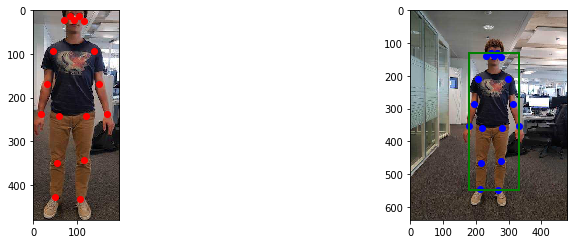

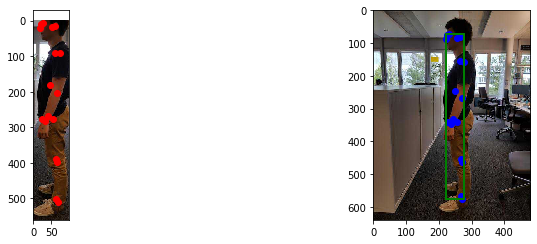

In [59]:
i=0
front_view = pifpaf[i]['conv_keypoints']
side_view = pifpaf[i+1]['conv_keypoints']
vs.show_pp_on_image(pifpaf[i],'./data/pifpaf/proportions_images/','.jpg')
vs.show_pp_on_image(pifpaf[i+1],'./data/pifpaf/proportions_images/','.jpg')

In [60]:
body_props_1, face_pos_1 = pose2d.get_proportions(front_view, side_view)

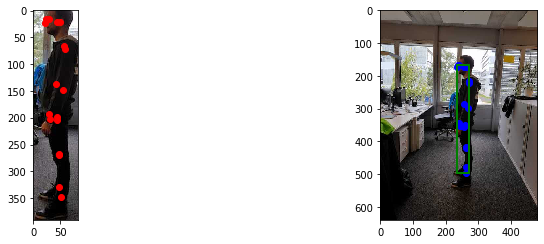

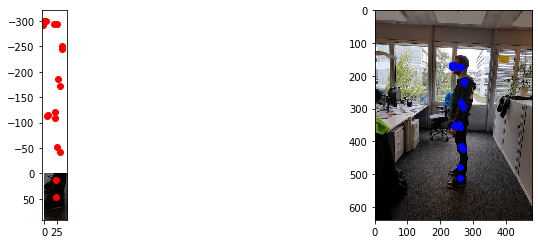

In [61]:
i=14
front_view = pifpaf[i]['conv_keypoints']
side_view = pifpaf[i+1]['conv_keypoints']
vs.show_pp_on_image(pifpaf[i],'./data/pifpaf/proportions_images/','.jpg')
vs.show_pp_on_image(pifpaf[i+1],'./data/pifpaf/proportions_images/','.jpg')

In [62]:
body_props_2, face_pos_2 = pose2d.get_proportions(front_view, side_view)

#### b- run the network on testing images

run pifpaf

In [51]:
! python3 -m openpifpaf.predict ./data/pifpaf/test_images/*  --force-complete-pose -o ./data/pifpaf/test_jsons/

/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'openpifpaf.network.nets.Shell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retri

In [63]:
pifpaf = pose2d.load_pifpaf('./data/pifpaf/test_jsons/')

we loaded 15 pedestrians


In [64]:
pifpaf = [x for x in pifpaf if np.mean(x['confidence'])>0.2]

In [65]:
len(pifpaf)

12

In [66]:
joints2keep = ['left hip', 'right hip', 'nose', 'right shoulder','left shoulder', 'right eye','left eye',
               'right ear','left ear','center shoulder','center hip','center back','head']

##### actor 1

In [67]:
preds_1 = []

for i in range(2,len(pifpaf)):
    test_input = pifpaf[i]['conv_keypoints']
    test_input = pose2d.filter_joints(test_input.reshape((21,2)).transpose(), joints2keep, 0)
    test_input = pose2d.normalize(test_input)
    test_input = pose2d.filter_joints(test_input, joints2keep, -10).transpose().flatten()
    
    test_props = [x[1] for x in body_props_1.items()]+reduce(lambda x, y: x+y, [x[1] for x in face_pos_1.items()])
    test_input = np.concatenate((test_input, test_props), axis = 0)
    
    test = infer(np.array([test_input]),net).cpu().numpy()[0]
    
    base_3d_pose = pose2d.generate_3D_model(body_props_1, face_pos_1)
    
    (a0,a1,a2,a3,a4,a5,a6,a7,a8) = test
    angle_dic = {'head':[a0,a1,a2], 'back':[a3,a4,a5], 'x':[a6],'y':[a7], 'z':[a8]}
    pred_pose = pose3d.full_pose_rotation(base_3d_pose.reshape((21,3)).transpose(), angle_dic).transpose().flatten()
    
    preds_1.append(pred_pose)
    

In [68]:
pifpaf[11]

{'ppbox': [38.846343994140625,
  194.56918334960938,
  240.83438110351562,
  287.4888610839844],
 'confidence': [0.9,
  1.0,
  0.0,
  0.9,
  0.0,
  0.8,
  0.7,
  0.8,
  0.5,
  0.6,
  0.5,
  0.7,
  0.4,
  0.0,
  0.2,
  0.0,
  0.0],
 'image_id': '000018',
 'og_keypoints': array([[232.8, 240.4, 235.6, 269.4, 254.5, 279.7, 263.2, 239. , 241.5,
         199. , 218.4, 228. , 206.2,  77.9,  81.6,  38.8,  39.3],
        [204.3, 194.6, 194.8, 205.2, 206.1, 259.7, 243.8, 341.2, 281.1,
         316.4, 292.8, 367.8, 343.1, 397. , 395.3, 482.1, 473. ]]),
 'conv_keypoints': array([ 5.42236823e-02, -5.25739130e-01,  1.60470665e-01, -3.88347826e-01,
         8.48770203e-02, -2.58608696e-01,  4.30069155e-03, -2.17913043e-01,
         2.18116713e-01, -3.33043478e-01,  7.63786304e-02, -4.95652174e-02,
        -6.33174997e-02, -1.35826087e-01, -3.80882952e-02, -4.29565217e-02,
        -4.72753291e-01,  1.38608696e-01, -6.20089815e-01,  4.08869565e-01,
         3.80882952e-02,  4.29565217e-02, -4.85660113e

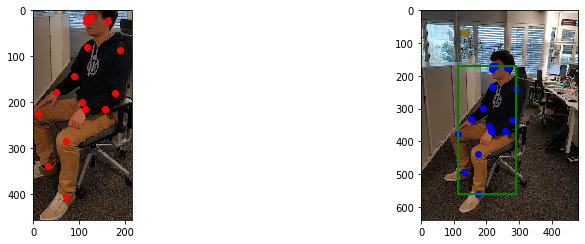

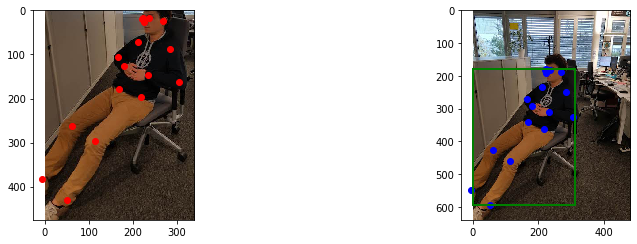

In [69]:
i,j = 1,8
vs.show_pp_on_image(pifpaf[i+2],'./data/pifpaf/test_images/','.jpg')
vs.show_pp_on_image(pifpaf[j+2],'./data/pifpaf/test_images/','.jpg')

In [70]:
pose2d.joint_dict

{'nose': 0,
 'right shoulder': 1,
 'right elbow': 2,
 'right wrist': 3,
 'left shoulder': 4,
 'left elbow': 5,
 'left wrist': 6,
 'right hip': 7,
 'right knee': 8,
 'right ankle': 9,
 'left hip': 10,
 'left knee': 11,
 'left ankle': 12,
 'right eye': 13,
 'left eye': 14,
 'right ear': 15,
 'left ear': 16,
 'center shoulder': 17,
 'center hip': 18,
 'center back': 19,
 'head': 20}

In [71]:
torso_co = [(0,20),(20,17),(17,19),(19,18),(0,13),(0,14),(13,15),(14,16),(1,4),(18,7),(18,10)]

In [72]:
go.Figure(vs.plot([preds_1[i],preds_1[j]], torso_co))

In [73]:
go.Figure(vs.plot(preds_1[5::2]))

##### actor 2

In [74]:
preds_2 = []

for i in range(2):
    test_input = pifpaf[i]['conv_keypoints']
    test_input = pose2d.filter_joints(test_input.reshape((21,2)).transpose(), joints2keep, 0)
    test_input = pose2d.normalize(test_input)
    test_input = pose2d.filter_joints(test_input, joints2keep, -10).transpose().flatten()
    
    test_props = [x[1] for x in body_props_2.items()]+reduce(lambda x, y: x+y, [x[1] for x in face_pos_2.items()])
    test_input = np.concatenate((test_input, test_props), axis = 0)
    
    test = infer(np.array([test_input]),net).cpu().numpy()[0]
    
    base_3d_pose = pose2d.generate_3D_model(body_props_2, face_pos_2)
    
    (a0,a1,a2,a3,a4,a5,a6,a7,a8) = test
    
    pred_pose = pose3d.full_pose_rotation(base_3d_pose.reshape((21,3)).transpose(), angle_dic).transpose().flatten()
    
    preds_2.append(pred_pose)
    

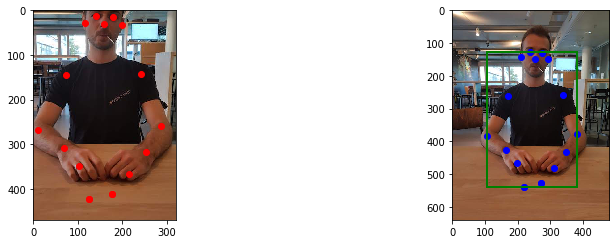

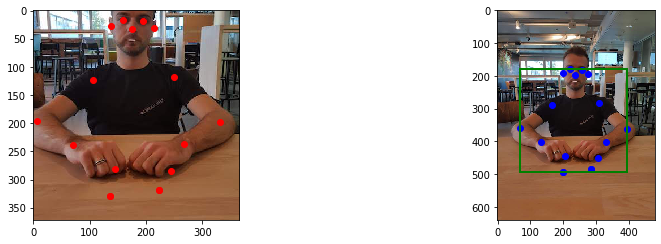

In [75]:
i,j = 0,1
vs.show_pp_on_image(pifpaf[i],'./data/pifpaf/test_images/','.jpg')
vs.show_pp_on_image(pifpaf[j],'./data/pifpaf/test_images/','.jpg')

In [76]:
go.Figure(vs.plot([preds_2[i],preds_2[j]], torso_co))

In [1]:
"""Display a live webcam feed. Require OpenCV (Python 2 only).
"""

try:
    import cv2
except Exception:
    raise ImportError("You need OpenCV for this example.")

import numpy as np
from vispy import app
from vispy import gloo

vertex = """
    attribute vec2 position;
    attribute vec2 texcoord;
    varying vec2 v_texcoord;
    void main()
    {
        gl_Position = vec4(position, 0.0, 1.0);
        v_texcoord = texcoord;
    }
"""

fragment = """
    uniform sampler2D texture;
    varying vec2 v_texcoord;
    void main()
    {
        gl_FragColor = texture2D(texture, v_texcoord);
        // HACK: the image is in BGR instead of RGB.
        float temp = gl_FragColor.r;
        gl_FragColor.r = gl_FragColor.b;
        gl_FragColor.b = temp;
    }
"""


class Canvas(app.Canvas):
    def __init__(self):
        app.Canvas.__init__(self, size=(640, 480), keys='interactive')
        self.program = gloo.Program(vertex, fragment, count=4)
        self.program['position'] = [(-1, -1), (-1, +1), (+1, -1), (+1, +1)]
        self.program['texcoord'] = [(1, 1), (1, 0), (0, 1), (0, 0)]
        self.program['texture'] = np.zeros((480, 640, 3)).astype(np.uint8)

        width, height = self.physical_size
        gloo.set_viewport(0, 0, width, height)

        self.cap = cv2.VideoCapture(0)
        if not self.cap.isOpened():
            raise Exception("There's no available camera.")
        self._timer = app.Timer('auto', connect=self.on_timer, start=True)

        self.show()

    def on_resize(self, event):
        width, height = event.physical_size
        gloo.set_viewport(0, 0, width, height)

    def on_draw(self, event):
        gloo.clear('black')
        _, im = self.cap.read()
        self.program['texture'][...] = im
        self.program.draw('triangle_strip')
        
    def on_timer(self, event):
        self.update()
        
c = Canvas()
app.run()
c.cap.release()

In [1]:
""" plot3d using existing visuals : LinePlotVisual """

import numpy as np
import sys

from vispy import app, visuals, scene

# build visuals
Plot3D = scene.visuals.create_visual_node(visuals.LinePlotVisual)

# build canvas
canvas = scene.SceneCanvas(keys='interactive', title='plot3d', show=True)

# Add a ViewBox to let the user zoom/rotate
view = canvas.central_widget.add_view()
view.camera = 'turntable'
view.camera.fov = 45
view.camera.distance = 6

# prepare data
N = 60
x = np.sin(np.linspace(-2, 2, N)*np.pi)
y = np.cos(np.linspace(-2, 2, N)*np.pi)
z = np.linspace(-2, 2, N)

# plot
pos = np.c_[x, y, z]
Plot3D(pos, width=2.0, color='red',
       edge_color='w', symbol='o', face_color=(0.2, 0.2, 1, 0.8),
       parent=view.scene)


if __name__ == '__main__':
    if sys.flags.interactive != 1:
        app.run()

/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/vispy/visuals/line/line.py:395: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('color', np.float32, 4)])
/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/vispy/visuals/line/arrow.py:57: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('linewidth', np.float32, 1)
/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/vispy/visuals/isocurve.py:22: UserWarning: VisPy is not yet compatible with matplotlib 2.2+
  warnings.warn("VisPy is not yet compatible with matplotlib 2.2+")
/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/vispy/visuals/markers.py:560: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future versio